<a href="https://colab.research.google.com/github/SMS-code-dot/F_Test1/blob/main/F_Test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### # Install the neededful


In [26]:
!pip install pandas numpy matplotlib seaborn streamlit prophet openpyxl

###

In [27]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.plot import plot_plotly
from sklearn.metrics import mean_squared_error, r2_score

## 1. Load the updated dataset


In [28]:
df = pd.read_excel('/content/Liberian_rice_price_prediction.xlsx')
df.head()

,Date,Region,Type,Price,FuelCost,ImportQuantity,ProductionQuantity,Weather_Rainfall(mm),Weather_Temperature(°C),FAO_GlobalRicePrice(USD/ton),Macro_InflationRate(%),Ministry_Subsidy(LRD)
0,10-05-2020,Waterside,Imported,3221,948,190,847,187,31,407,12.4,161
1,18-07-2021,Red Light Market,Imported,3795,1039,213,781,179,30,403,9.6,179
2,04-02-2021,Waterside,Imported,3130,943,180,828,185,34,420,10.0,158
3,31-12-2020,Duala,Local,3847,912,196,729,108,29,548,10.0,202
4,27-06-2022,Duala,Imported,3183,977,279,825,96,31,424,10.8,210


# 2. Preprocessing
## Convert date


In [29]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date', 'Price'])
df = df.sort_values('Date')

# 3. Group by month and average prices


In [30]:
df['MonthPeriod'] = df['Date'].dt.to_period('M')
monthly_avg = df.groupby('MonthPeriod')['Price'].mean().reset_index()
monthly_avg['Date'] = monthly_avg['MonthPeriod'].dt.to_timestamp()


# 4. Prepare data

In [31]:
prophet_df = monthly_avg.rename(columns={
    'Date': 'ds',
    'Price': 'y'
})


## 5. Define special events/holidays (extended realistic events)

In [32]:
special_events = pd.DataFrame({
    'holiday': [
        'covid_lockdown', 'food_subsidy_intro', 'election_period',
        'fuel_price_spike', 'import_disruption', 'harvest_season_start',
        'currency_change', 'external_aid_injection'
    ],
    'ds': pd.to_datetime([
        '2020-04-01', '2021-06-01', '2023-10-01',
        '2019-07-01', '2022-08-01', '2021-09-01',
        '2022-05-01', '2023-01-01'
    ]),
    'lower_window': 0,
    'upper_window': 2
})


## 6. Build and fit Prophet model with ultra fine-tuned settings

In [33]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.008,
    n_changepoints=100,
    changepoint_range=0.95,
    seasonality_mode='multiplicative',
    interval_width=0.99,
    holidays=special_events
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='quarterly', period=90, fourier_order=7)
model.add_seasonality(name='semiannual', period=180, fourier_order=10)
model.add_seasonality(name='triannual', period=120, fourier_order=12)
model.fit(prophet_df)


INFO:prophet:n_changepoints greater than number of observations. Using 78.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbyad96f5/s3j0w7pl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbyad96f5/qljo_vbh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37638', 'data', 'file=/tmp/tmpbyad96f5/s3j0w7pl.json', 'init=/tmp/tmpbyad96f5/qljo_vbh.json', 'output', 'file=/tmp/tmpbyad96f5/prophet_modelpeow6qwr/prophet_model-20250511084647.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:46:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:46:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## 7. Create future dataframe

In [34]:
future = model.make_future_dataframe(periods=12, freq='ME')


## 8. Forecast

In [35]:
forecast = model.predict(future)


## 9. Evaluation

In [36]:
actual = prophet_df.set_index('ds').copy()
predicted = forecast.set_index('ds').loc[actual.index]['yhat']

r2 = r2_score(actual['y'], predicted)
rmse = np.sqrt(mean_squared_error(actual['y'], predicted))
print(f'R2 Score: {r2:.4f}')
print(f'RMSE: {rmse:.2f}')



R2 Score: 0.9105
RMSE: 29.11


# 10. Plot forecast

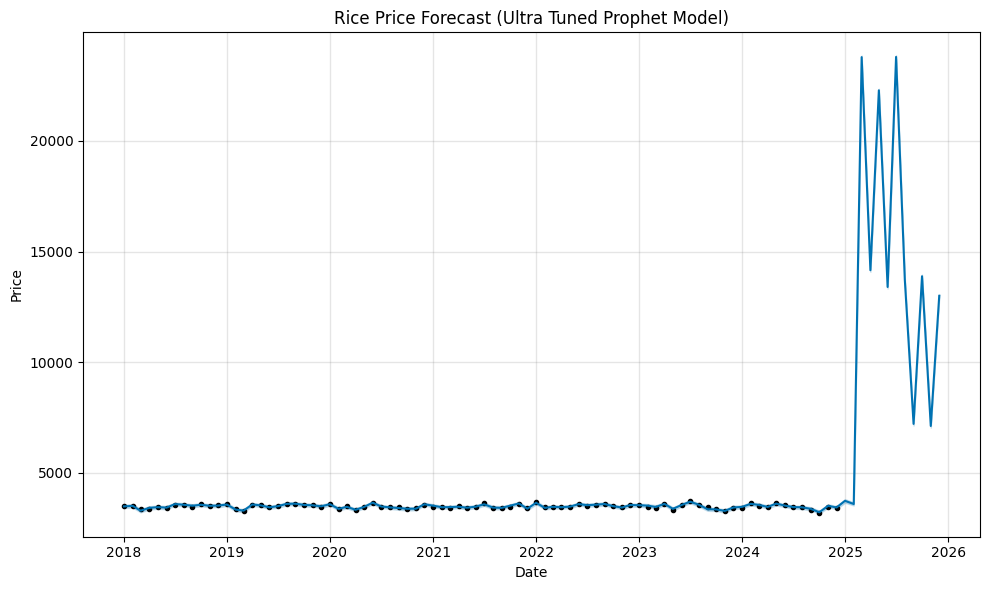

In [37]:
model.plot(forecast)
plt.title("Rice Price Forecast (Ultra Tuned Prophet Model)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()


## 11. Plot components

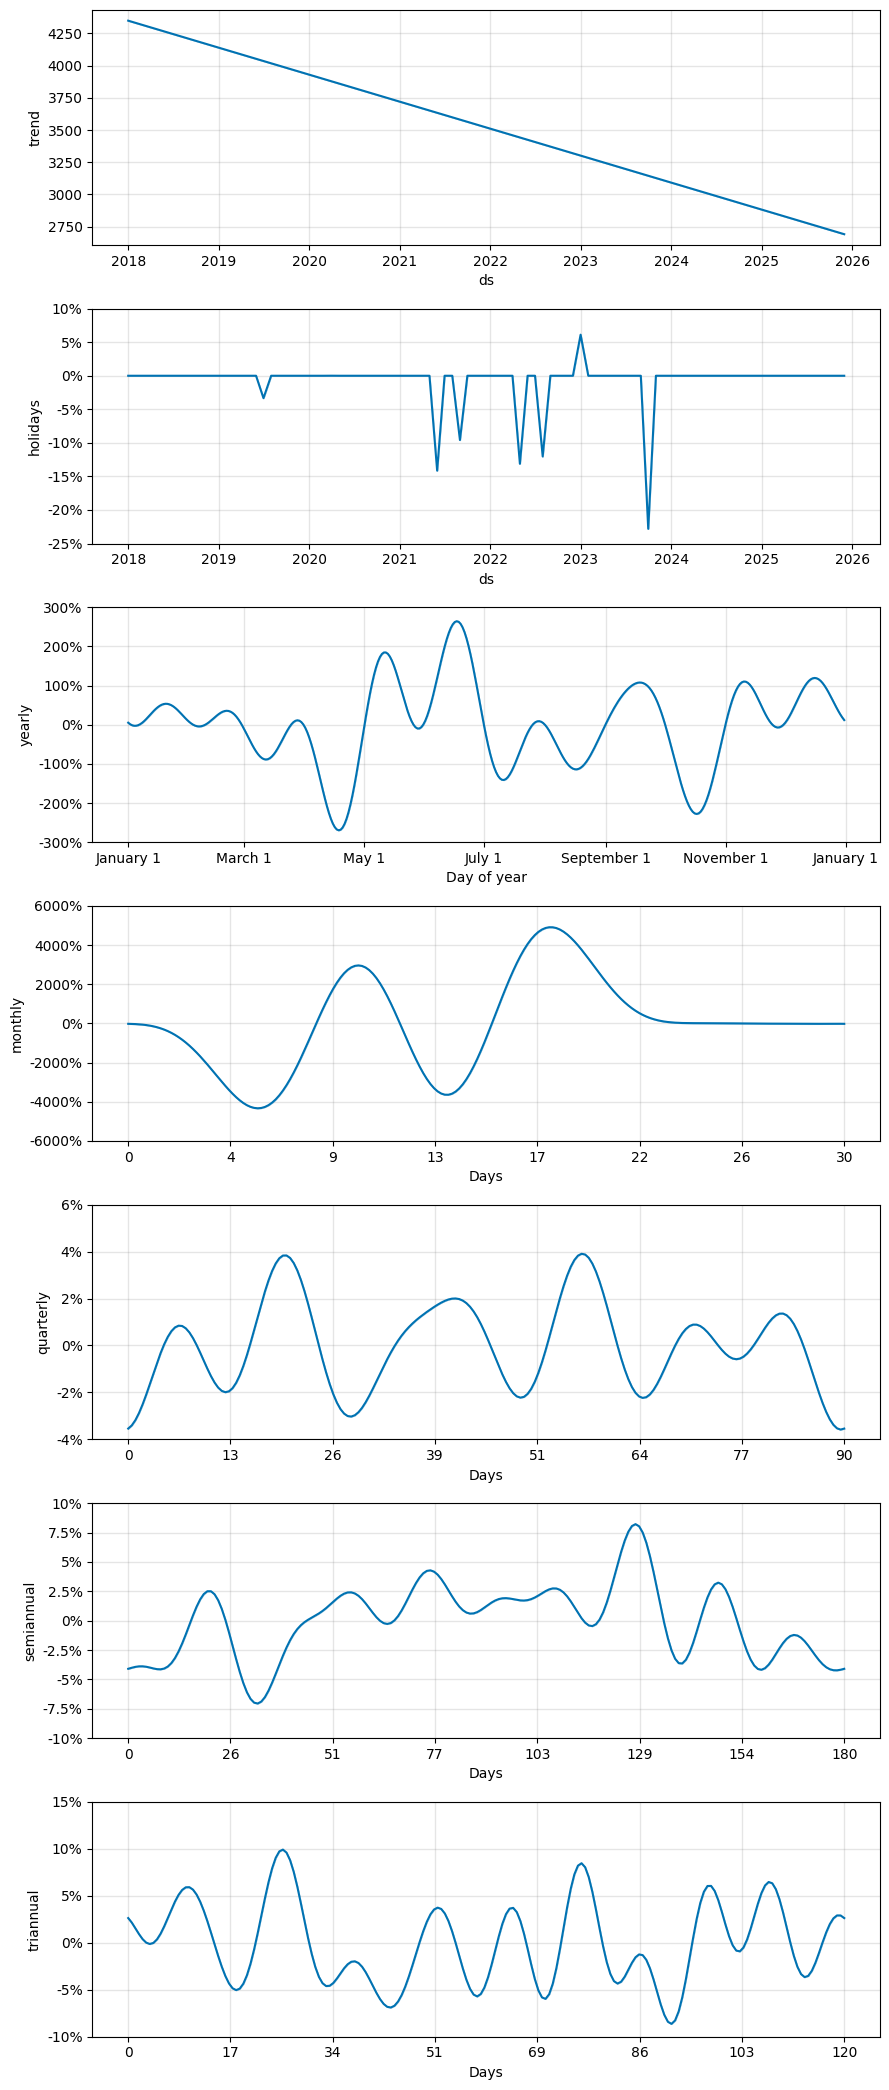

In [38]:
model.plot_components(forecast)
plt.tight_layout()
plt.show()


## 12. Plot actual vs predicted

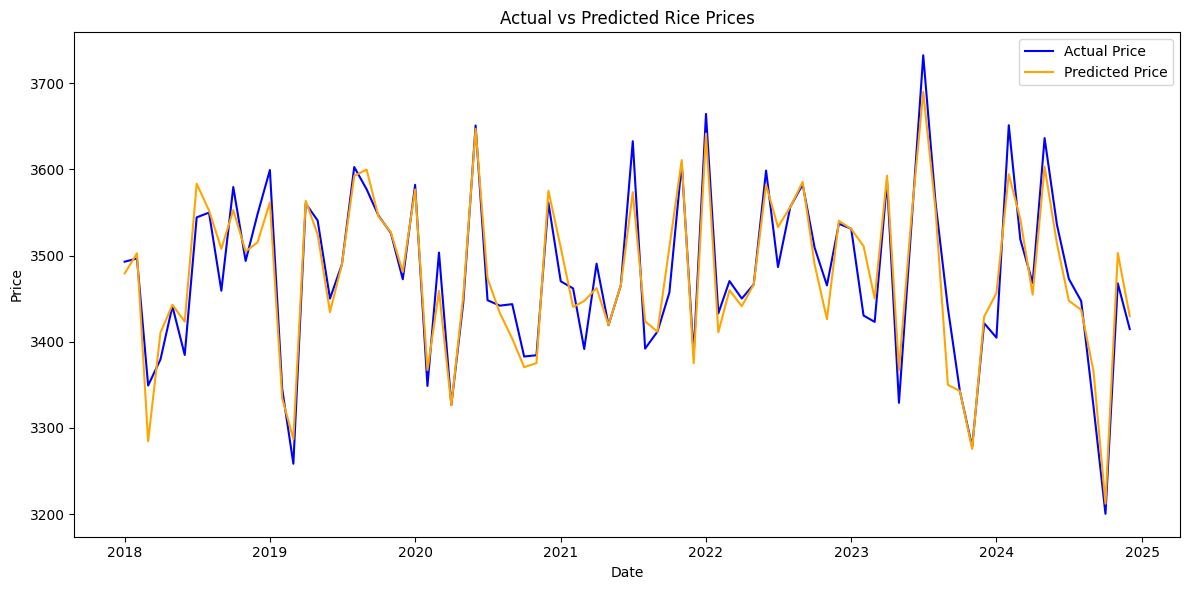

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(actual.index, actual['y'], label='Actual Price', color='blue')
plt.plot(actual.index, predicted, label='Predicted Price', color='orange')
plt.title('Actual vs Predicted Rice Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 66.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbyad96f5/jgw8d_ds.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbyad96f5/h0u4xjur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40531', 'data', 'file=/tmp/tmpbyad96f5/jgw8d_ds.json', 'init=/tmp/tmpbyad96f5/h0u4xjur.json', 'output', 'file=/tmp/tmpbyad96f5/prophet_modeljhc5x2aw/prophet_model-20250511085132.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:51:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:51:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:

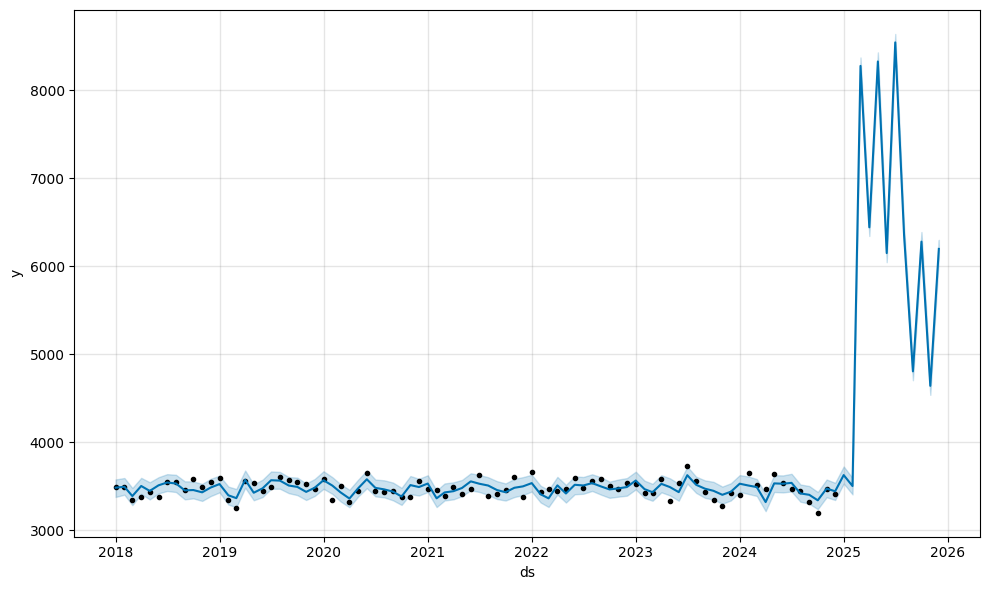

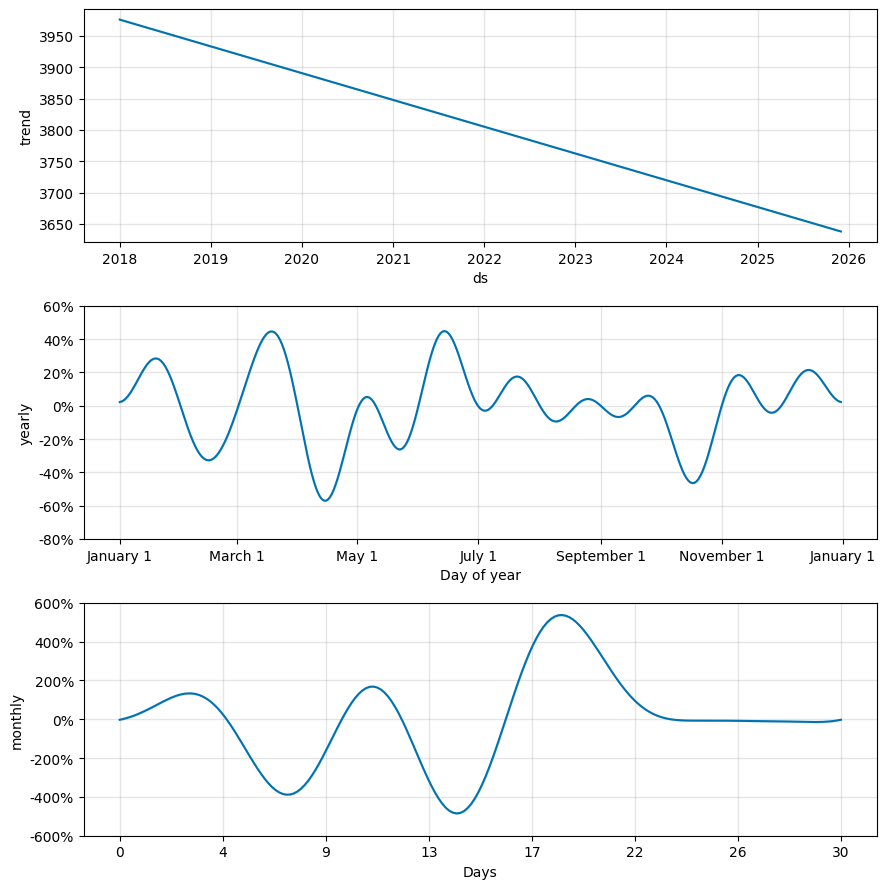

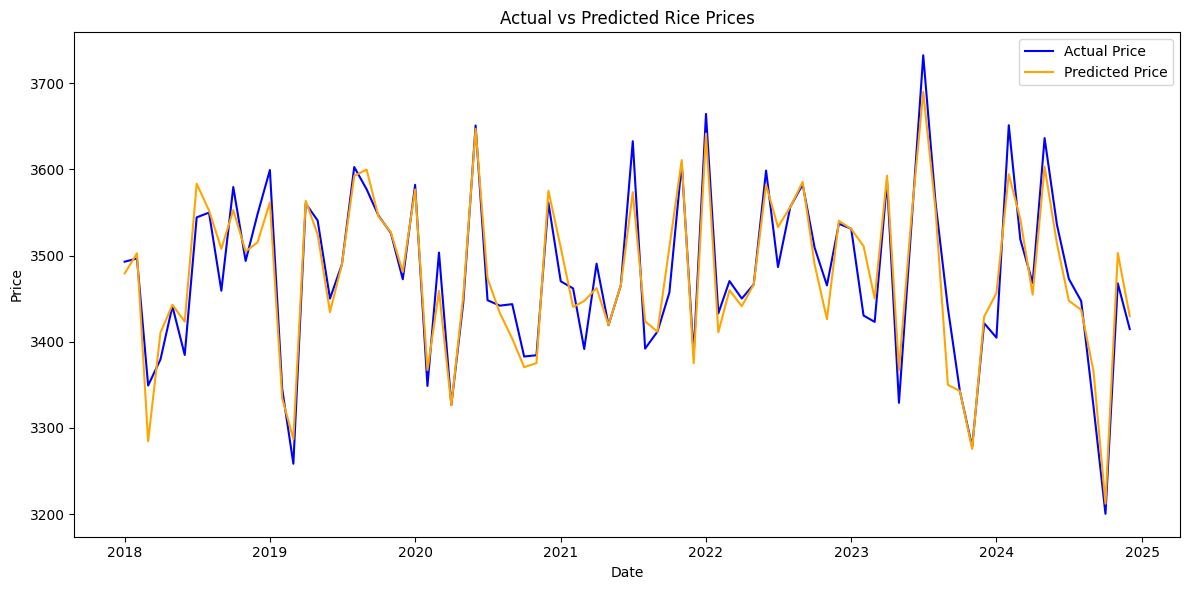

<ipython-input-43-1c3ae72fb730>:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


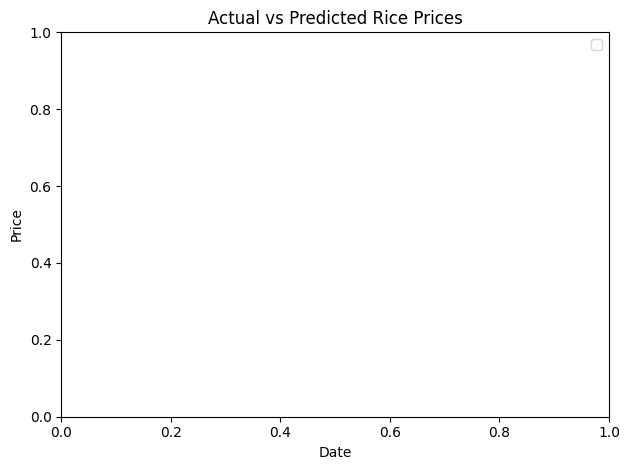

In [43]:
# 1. Data Loading & Preprocessing
df = pd.read_excel('/content/Liberian_rice_price_prediction.xlsx')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date', 'Price'])

# 2. Monthly Aggregation
df['MonthPeriod'] = df['Date'].dt.to_period('M')
monthly_avg = df.groupby('MonthPeriod')['Price'].mean().reset_index()
monthly_avg['Date'] = monthly_avg['MonthPeriod'].dt.to_timestamp()

# 3. Prophet Model Setup
prophet_df = monthly_avg.rename(columns={'Date': 'ds', 'Price': 'y'})
model = Prophet(
    yearly_seasonality=True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.008,
    n_changepoints=100
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(prophet_df)

# 4. Forecasting
future = model.make_future_dataframe(periods=12, freq='ME')
forecast = model.predict(future)

# 1. Data Loading & Preprocessing
df = pd.read_excel('/content/Liberian_rice_price_prediction.xlsx')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date', 'Price'])

# 2. Monthly Aggregation
df['MonthPeriod'] = df['Date'].dt.to_period('M')
monthly_avg = df.groupby('MonthPeriod')['Price'].mean().reset_index()
monthly_avg['Date'] = monthly_avg['MonthPeriod'].dt.to_timestamp()

# 3. Prophet Model Setup
prophet_df = monthly_avg.rename(columns={'Date': 'ds', 'Price': 'y'})
model = Prophet(
    yearly_seasonality=True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.008,
    n_changepoints=100
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(prophet_df)

# 4. Forecasting
future = model.make_future_dataframe(periods=12, freq='ME')
forecast = model.predict(future)

# 5. Plotting (to be adapted for Streamlit)
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)
plt.figure(figsize=(12, 6))
plt.plot(actual.index, actual['y'], label='Actual Price', color='blue')
plt.plot(actual.index, predicted, label='Predicted Price', color='orange')
plt.title('Actual vs Predicted Rice Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()
plt.title('Actual vs Predicted Rice Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [44]:

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
# --- App Config ---
st.set_page_config(page_title="Rice Price Forecast", layout="wide")
st.title("🌾 Liberian Rice Price Forecasting Tool")

# --- Sidebar Controls ---
with st.sidebar:
    st.header("Settings")
    months_to_forecast = st.slider("Forecast Period (months):", 1, 24, 12)
    confidence_interval = st.slider("Confidence Interval:", 0.8, 0.99, 0.95)

# --- Data Loading ---
uploaded_file = st.file_uploader("/content/Liberian_rice_price_prediction.xlsx", type=["xlsx"])
if uploaded_file:
    # 1. Preprocess Data (extracted from notebook)
    df = pd.read_excel(uploaded_file)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.dropna(subset=['Date', 'Price'])

    # 2. Monthly Aggregation
    df['MonthPeriod'] = df['Date'].dt.to_period('M')
    monthly_avg = df.groupby('MonthPeriod')['Price'].mean().reset_index()
    monthly_avg['Date'] = monthly_avg['MonthPeriod'].dt.to_timestamp()

    # 3. Prophet Model (with user-adjustable parameters)
    prophet_df = monthly_avg.rename(columns={'Date': 'ds', 'Price': 'y'})
    model = Prophet(
        yearly_seasonality=True,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.008,
        n_changepoints=100,
        interval_width=confidence_interval  # From sidebar
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(prophet_df)

    # 4. Forecasting
    future = model.make_future_dataframe(periods=months_to_forecast, freq='ME')
    forecast = model.predict(future)

    # --- Results Visualization ---
    st.subheader("Price Forecast")
    fig1 = model.plot(forecast)
    st.pyplot(fig1)

    st.subheader("Trend Components")
    fig2 = model.plot_components(forecast)
    st.pyplot(fig2)

    # --- Data Export ---
    st.download_button(
        label="Download Forecast as CSV",
        data=forecast.to_csv().encode('utf-8'),
        file_name="rice_price_forecast.csv"
    )
else:
    st.warning("Please upload an Excel file to begin.")

2025-05-11 08:52:24.872 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 08:52:24.875 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 08:52:24.876 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 08:52:24.877 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 08:52:24.878 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 08:52:24.879 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 08:52:24.879 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-11 08:52:24.880 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar